In [1]:
import ROOT as root
import numpy as np
import random
from timer import Timer

t = Timer()
t.start()

Welcome to JupyROOT 6.24/08


In [2]:
fileName = "rootfiles/test40.root"
treeName = "tdata"

f = root.TFile(fileName)
myTree = f.Get(treeName)

myTree.Print()

root.EnableImplicitMT()
d = root.RDataFrame(treeName,fileName)

******************************************************************************
*Tree    :tdata     : Run 40                                                 *
*Entries :  2377591 : Total =       304763218 bytes  File  Size =   60328496 *
*        :          : Tree compression factor =   5.05                       *
******************************************************************************
*Br    0 :adc       : adc[16]/I                                              *
*Entries :  2377591 : Total  Size=  152381435 bytes  File Size  =   43404150 *
*Baskets :     2366 : Basket Size=    3200512 bytes  Compression=   3.51     *
*............................................................................*
*Br    1 :tdc       : tdc[16]/I                                              *
*Entries :  2377591 : Total  Size=  152381435 bytes  File Size  =   16882839 *
*Baskets :     2366 : Basket Size=    3200512 bytes  Compression=   9.02     *
*...................................................

Warning in <EnableImplicitMT>: Cannot enable implicit multi-threading with 0 threads, please build ROOT with -Dimt=ON


In [3]:
triggercode='''
using namespace std;
using RNode = ROOT::RDF::RNode;
std::vector<RNode> v;

bool remakepedfile= false;
const int bin = 100;
const Int_t Nadc = 16;
const Int_t Ntdc = 16;
const Int_t pedrun = 172;
const Int_t bl=Ntdc-16+0;//Start at channel 0
const Int_t br=Ntdc-16+1;
const Int_t tl=Ntdc-16+2;
const Int_t tr=Ntdc-16+3;
const Int_t tdc_min = 500;
const Int_t tdc_max = 3500;
//const Double_t adjadcto=1400.0;//value to ADJust ADC TO
Double_t t_fullscale = 140.0E-09; // full scale TDC range in seconds
Double_t t_convert=t_fullscale/4096.0;

const Int_t nthetabins = 51;
const Double_t thetalow = -100.5;
const Double_t thetahigh = 100.5;

const Double_t nscint=1.50;

Double_t vn = 2.997E08/nscint;
Double_t resolution = 0.934*(0.0232*nscint*nscint-0.1061*nscint+0.1617);
Double_t granularity = t_convert*vn/2.0;
Double_t xpos_range = 0.30;
Double_t dscint = 0.105; // distance between scintillators in metres
const int xposbin = 2.0*xpos_range/granularity;

Char_t tdcnames[][Ntdc]={"Bottom Left","Bottom Right","Top Left","Top Right","4","5","6","7","8","9","10","11","12","13","14","15"};
Char_t adcnames[][Nadc]={"Bottom Left","Bottom Right","Top Left","Top Right","4","5","6","7","8","9","10","11","12","13","14","15"};

Double_t tdccorrect[Ntdc];
Double_t ped[Nadc];
Double_t gain[Nadc];

TRandom r;
Double_t rnd;

bool getTrigger(int* tdc, int* adc) {

        bool tdc_tl = false;
        bool tdc_tr = false;
        bool tdc_bl = false;
        bool tdc_br = false;
        bool trigger = false;

        if (tdc[tl]>tdc_min&&tdc[tl]<tdc_max) {
                tdc_tl = true;
        }
        if (tdc[tr]>tdc_min&&tdc[tr]<tdc_max) {
                tdc_tr = true;
        }
        if (tdc[bl]>tdc_min&&tdc[bl]<tdc_max) {
                tdc_bl = true;
        }
        if (tdc[br]>tdc_min&&tdc[br]<tdc_max) {
                tdc_br = true;
        }

        if (tdc_tl && tdc_tr && tdc_bl && tdc_br) {
                trigger = true;
        }

        return trigger;
}

float getTheta2(bool trigger, float xtop, float xbottom) {

        double rtod=180.0/3.14159265;
        Double_t rnd_top_pos = r.Gaus(0.0,resolution);
        Double_t rnd_bottom_pos = r.Gaus(0.0,resolution);

        TF1 *fphi = new TF1("fsin", "x", 0, 2*TMath::Pi());
        TF1 *fcos = new TF1("fcos", "cos(x)*cos(x)",-TMath::Pi()/2.0,TMath::Pi()/2.0);
        Double_t phisim, cossim, rndxt, rndyt, rndrt, rndrr, rndxb, rndyb;
        while (true) {
            phisim = fphi->GetRandom();
            cossim = fcos->GetRandom();
            rndxt = r.Uniform(-0.10,0.10);
            rndyt = r.Uniform(-0.15,0.15);
            rndrt = sqrt(rndxt*rndxt+rndyt*rndyt)+rnd_top_pos;
            rndrr = dscint*tan(cossim);
            rndxb = rndxt+rndrr*cos(phisim);
            rndyb = rndyt+rndrr*sin(phisim);
            if (rndxb > -0.10 && rndxb < 0.10 && rndyb > -0.15 && rndyb < 0.15) break;
        }

        Double_t rndrb = sqrt(rndxb*rndxb+rndyb*rndyb)+rnd_bottom_pos;
        Double_t theta2 = 0.8281-rtod*atan((rndrt-rndrb)/dscint);

        if (trigger) {
                return theta2;
        }

        return -1000;

}

float getTheta(bool trigger, float xtop, float xbottom) {

    double rtod=180.0/3.14159265;
    if (trigger) {
        rnd = r.Gaus(0.0,1.5);
        return rtod*atan((xbottom-xtop)/dscint)+rnd;
    }

    return -1000;

}

float getXTop(bool trigger, double ttl, double ttr, double tbl, double tbr) {

        //std::vector<float> v;

        if(trigger) {
                return (ttl-ttr)/2.0*t_convert*vn;
        }

        return -1000;
}

float getXMeanTop(bool trigger, double ttl, double ttr, double tbl, double tbr) {

        //std::vector<float> v;

        if(trigger) {
                return (ttl+ttr-4000.0)*t_convert*vn;
        }

        return -1000;
}

float getXMean(bool trigger, double xmeantop, double xmeanbottom) {

        //std::vector<float> v;

        if(trigger) {
                return (xmeantop-xmeanbottom)/2.0;
        }

        return -1000;
}

float getXBottom(bool trigger, double ttl, double ttr, double tbl, double tbr) {

        //std::vector<float> v;

        if(trigger) {
                return (tbl-tbr)/2.0*t_convert*vn;
        }

        return -1000;
}

float getXMeanBottom(bool trigger, double ttl, double ttr, double tbl, double tbr) {

        //std::vector<float> v;

        if(trigger) {
                return (tbl+tbr-4000.0)*t_convert*vn;
        }

        return -1000;
}

float getERatio(bool trigger, double etop, double ebottom) {

        if (trigger) {
                return etop/ebottom;
        }

        return -1000;
}

float getETop(bool trigger, double adctl, double adctr) {

        if (trigger) {
                return (adctr+adctl)/2.0;
        }

        return -1000;
}

float getEBottom(bool trigger, double adcbl, double adcbr) {

        if (trigger) {
                return (adcbr+adcbl)/2.0;
        }

        return -1000;
}
'''

root.gInterpreter.Declare(triggercode)

True

In [4]:
fdf = d.Define("trigger","getTrigger(&tdc[0],&adc[0])")

entries = d.Count();
print('{} entries'.format(entries.GetValue()))

triggers = fdf.Filter("trigger==true").Count()
print('{} entries passed trigger'.format(triggers.GetValue()))

fdft = fdf.Filter("trigger==true")

2377591 entries
1500505 entries passed trigger


In [5]:
fdftt = fdft.Define("tdctl","tdc[0]") \
            .Define("tdctr","tdc[1]") \
            .Define("tdcbl","tdc[2]") \
            .Define("tdcbr","tdc[3]") \
            .Define("adctl","adc[0]") \
            .Define("adctr","adc[1]") \
            .Define("adcbl","adc[2]") \
            .Define("adcbr","adc[3]")

In [6]:
tdctl0 = fdftt.Mean("tdctl").GetValue()
tdctr0 = fdftt.Mean("tdctr").GetValue()
tdcbl0 = fdftt.Mean("tdcbl").GetValue()
tdcbr0 = fdftt.Mean("tdcbr").GetValue()
print(tdctl0,tdctr0,tdcbl0,tdcbr0)
adctl0 = fdftt.Mean("adctl").GetValue()
adctr0 = fdftt.Mean("adctr").GetValue()
adcbl0 = fdftt.Mean("adcbl").GetValue()
adcbr0 = fdftt.Mean("adcbr").GetValue()
print(adctl0,adctr0,adcbl0,adcbr0)
adjadcto=1400.0

1826.348056154428 1858.6703316550095 1875.1438422397794 1899.8724822643044
696.3570464610248 496.1416656392348 656.7744039506699 529.0393347572983


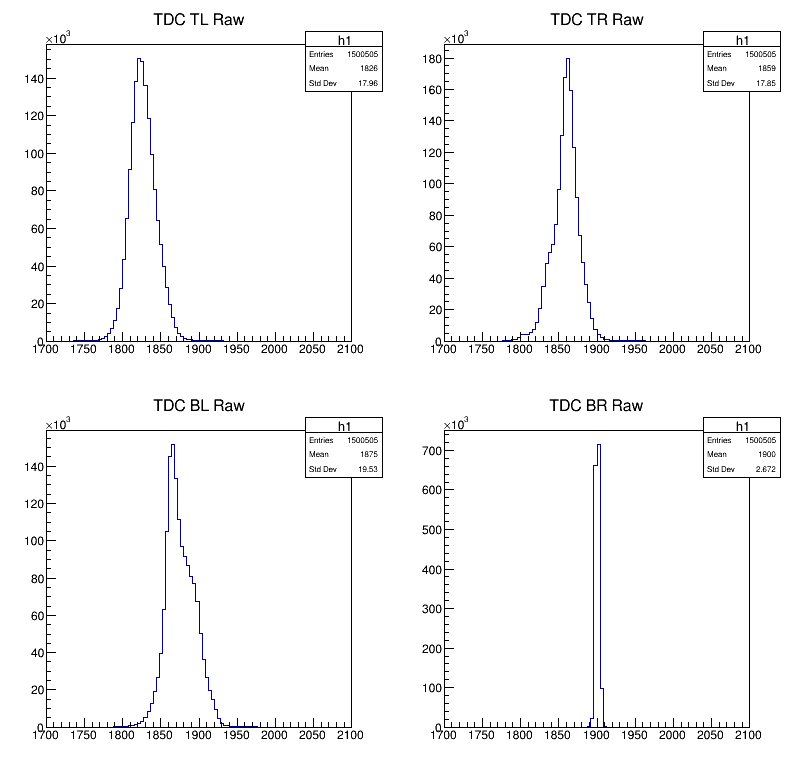

In [7]:
# Canvas 1
htdctl = fdftt.Histo1D(("h1", "TDC TL Raw", 100, 1700.0, 2100.0),'tdctl')
htdctr = fdftt.Histo1D(("h1", "TDC TR Raw", 100, 1700.0, 2100.0),'tdctr')
htdcbl = fdftt.Histo1D(("h1", "TDC BL Raw", 100, 1700.0, 2100.0),'tdcbl')
htdcbr = fdftt.Histo1D(("h1", "TDC BR Raw", 100, 1700.0, 2100.0),'tdcbr')

c1 = root.TCanvas("c1","c1",800,800)
c1.Divide(2,2,0.01,0.01,0)

c1.cd(1)
htdctl.Draw()
c1.cd(2)
htdctr.Draw()
c1.cd(3)
htdcbl.Draw()
c1.cd(4)
htdcbr.Draw()

c1.Draw()

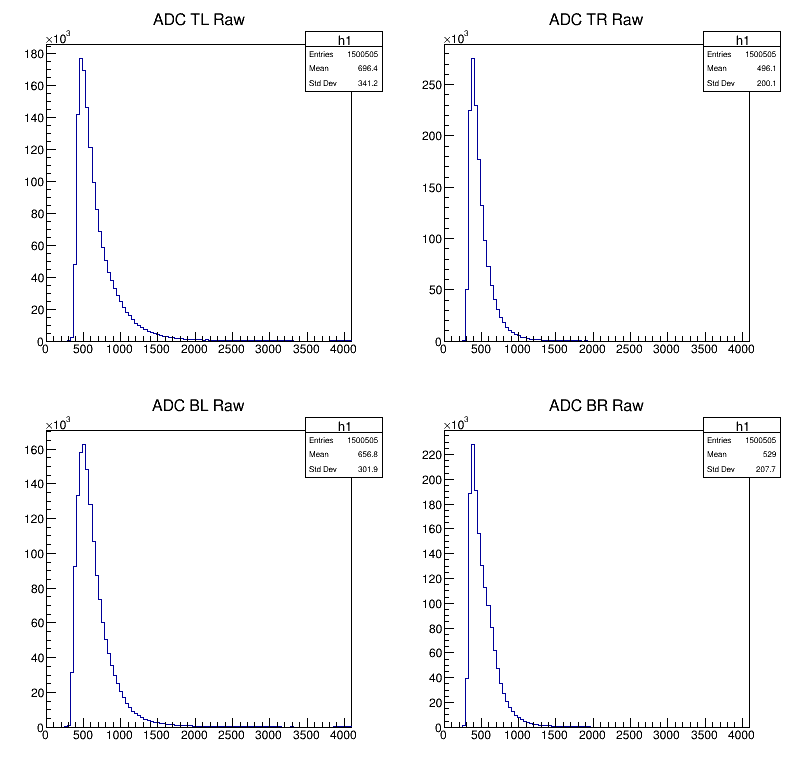

In [8]:
# Canvas 3
hadctl = fdftt.Histo1D(("h1", "ADC TL Raw", 100, 0.0, 4100.0),'adctl')
hadctr = fdftt.Histo1D(("h1", "ADC TR Raw", 100, 0.0, 4100.0),'adctr')
hadcbl = fdftt.Histo1D(("h1", "ADC BL Raw", 100, 0.0, 4100.0),'adcbl')
hadcbr = fdftt.Histo1D(("h1", "ADC BR Raw", 100, 0.0, 4100.0),'adcbr')

c3 = root.TCanvas("c3","c3",800,800)
c3.Divide(2,2,0.01,0.01,0)

c3.cd(1)
hadctl.Draw()
c3.cd(2)
hadctr.Draw()
c3.cd(3)
hadcbl.Draw()
c3.cd(4)
hadcbr.Draw()

c3.Draw()

In [9]:
from ROOT import *

def read_peds(filename):
    values = []
    with open(filename, 'r') as file:
        for line in file:
            try:
                value = float(line.strip())
                values.append(value)
            except ValueError:
                pass  # Skip lines that can't be converted to floats
    return values

ped = read_peds("./pedestalfiles/pedestalrun172.dat")

pedtl=ped[0]
pedtr=ped[1]
pedbl=ped[2]
pedbr=ped[3]

gInterpreter.Declare('float tdctl0 = float(TPython::Eval("tdctl0"));')
gInterpreter.Declare('float tdctr0 = float(TPython::Eval("tdctr0"));')
gInterpreter.Declare('float tdcbl0 = float(TPython::Eval("tdcbl0"));')
gInterpreter.Declare('float tdcbr0 = float(TPython::Eval("tdcbr0"));')
gInterpreter.Declare('float adctl0 = float(TPython::Eval("adctl0"));')
gInterpreter.Declare('float adctr0 = float(TPython::Eval("adctr0"));')
gInterpreter.Declare('float adcbl0 = float(TPython::Eval("adcbl0"));')
gInterpreter.Declare('float adcbr0 = float(TPython::Eval("adcbr0"));')
gInterpreter.Declare('float pedtl = float(TPython::Eval("pedtl"));')
gInterpreter.Declare('float pedtr = float(TPython::Eval("pedtr"));')
gInterpreter.Declare('float pedbl = float(TPython::Eval("pedbl"));')
gInterpreter.Declare('float pedbr = float(TPython::Eval("pedbr"));')

gInterpreter.Declare('float adjadcto = float(TPython::Eval("adjadcto"));')

fdfttt = fdftt.Define("tdctladj", "tdc[0]-tdctl0+2000;") \
              .Define("tdctradj", "tdc[1]-tdctr0+2000;") \
              .Define("tdcbladj", "tdc[2]-tdcbl0+2000;") \
              .Define("tdcbradj", "tdc[3]-tdcbr0+2000;") \
              .Define("adctladj", "(adc[0]-pedtl)*adjadcto/(adctl0-pedtl);") \
              .Define("adctradj", "(adc[1]-pedtr)*adjadcto/(adctr0-pedtr);") \
              .Define("adcbladj", "(adc[2]-pedbl)*adjadcto/(adcbl0-pedbl);") \
              .Define("adcbradj", "(adc[3]-pedbr)*adjadcto/(adcbr0-pedbr);")

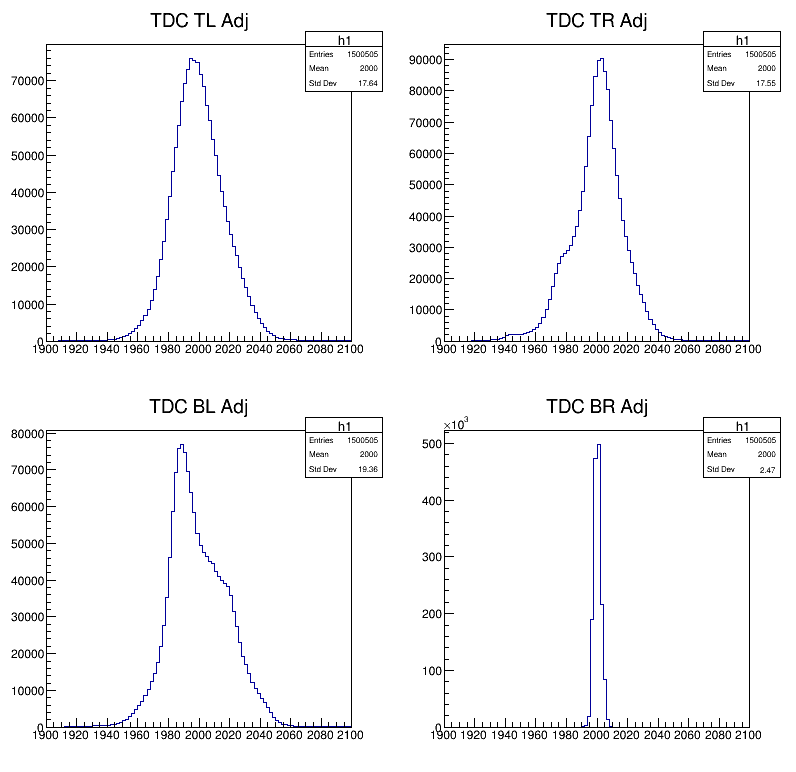

In [10]:
# Canvas 2
htdctladj = fdfttt.Histo1D(("h1", "TDC TL Adj", 100, 1900.0, 2100.0),'tdctladj')
htdctradj = fdfttt.Histo1D(("h1", "TDC TR Adj", 100, 1900.0, 2100.0),'tdctradj')
htdcbladj = fdfttt.Histo1D(("h1", "TDC BL Adj", 100, 1900.0, 2100.0),'tdcbladj')
htdcbradj = fdfttt.Histo1D(("h1", "TDC BR Adj", 100, 1900.0, 2100.0),'tdcbradj')

c2 = root.TCanvas("c2","c2",800,800)
c2.Divide(2,2,0.01,0.01,0)

c2.cd(1)
htdctladj.Draw()
c2.cd(2)
htdctradj.Draw()
c2.cd(3)
htdcbladj.Draw()
c2.cd(4)
htdcbradj.Draw()

c2.Draw()

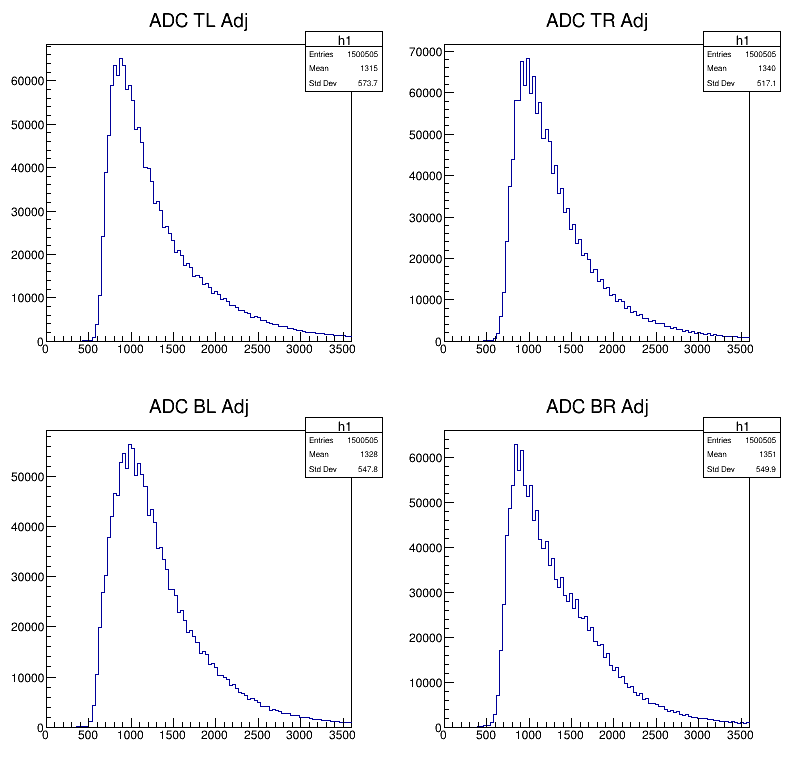

In [11]:
# Canvas 4
hadctladj = fdfttt.Histo1D(("h1", "ADC TL Adj", 100, 0.0, 3600.0),'adctladj')
hadctradj = fdfttt.Histo1D(("h1", "ADC TR Adj", 100, 0.0, 3600.0),'adctradj')
hadcbladj = fdfttt.Histo1D(("h1", "ADC BL Adj", 100, 0.0, 3600.0),'adcbladj')
hadcbradj = fdfttt.Histo1D(("h1", "ADC BR Adj", 100, 0.0, 3600.0),'adcbradj')

c4 = root.TCanvas("c4","c4",800,800)
c4.Divide(2,2,0.01,0.01,0)

c4.cd(1)
hadctladj.Draw()
c4.cd(2)
hadctradj.Draw()
c4.cd(3)
hadcbladj.Draw()
c4.cd(4)
hadcbradj.Draw()

c4.Draw()

In [12]:
fdftttt = fdfttt.Define("xtop","getXTop(trigger,tdctladj,tdctradj,tdcbladj,tdcbradj)") \
            .Define("xbottom","getXBottom(trigger,tdctladj,tdctradj,tdcbladj,tdcbradj)") \
            .Define("xmeantop","getXMeanTop(trigger,tdctladj,tdctradj,tdcbladj,tdcbradj)") \
            .Define("xmeanbottom","getXMeanBottom(trigger,tdctladj,tdctradj,tdcbladj,tdcbradj)") \
            .Define("xmean","getXMean(trigger,xmeantop,xmeanbottom)") \
            .Define("theta","getTheta(trigger,xtop,xbottom)") \
            .Define("theta2","getTheta2(trigger,xtop,xbottom)") \
            .Define("etop","getETop(trigger,adctladj,adctradj)") \
            .Define("ebottom","getEBottom(trigger,adcbladj,adcbradj)") \
            .Define("eratio","getERatio(trigger,etop,ebottom)")

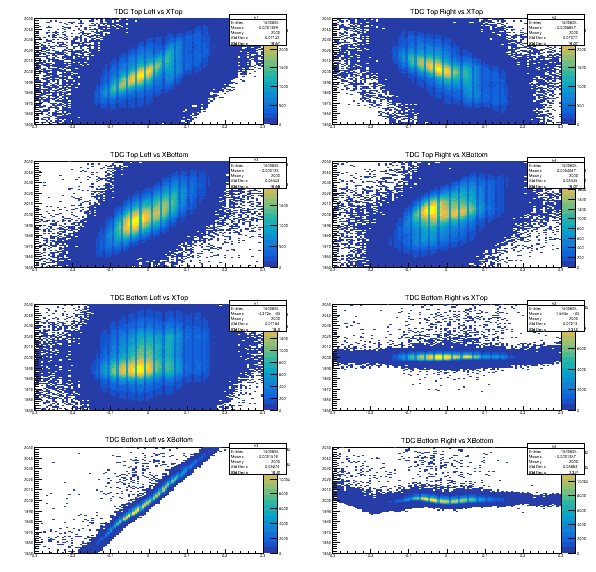

In [13]:
bin = 100

c6 = root.TCanvas("c6", "c6", 112,112,600,600);
c6.Divide(2,4, 0.01, 0.01, 0);

hTDCTLvsXT = fdftttt.Histo2D(("h1","TDC Top Left vs XTop",bin,-0.3,0.3,bin,1950,2050),"xtop","tdctladj");
hTDCTRvsXT = fdftttt.Histo2D(("h2","TDC Top Right vs XTop",bin,-0.3,0.3,bin,1950,2050),"xtop","tdctradj");
hTDCTLvsXB = fdftttt.Histo2D(("h3","TDC Top Left vs XBottom",bin,-0.3,0.3,bin,1950,2050),"xbottom","tdctladj");
hTDCTRvsXB = fdftttt.Histo2D(("h4","TDC Top Right vs XBottom",bin,-0.3,0.3,bin,1950,2050),"xbottom","tdctradj");
hTDCBLvsXT = fdftttt.Histo2D(("h1","TDC Bottom Left vs XTop",bin,-0.3,0.3,bin,1950,2050),"xtop","tdcbladj");
hTDCBRvsXT = fdftttt.Histo2D(("h2","TDC Bottom Right vs XTop",bin,-0.3,0.3,bin,1950,2050),"xtop","tdcbradj");
hTDCBLvsXB = fdftttt.Histo2D(("h3","TDC Bottom Left vs XBottom",bin,-0.3,0.3,bin,1950,2050),"xbottom","tdcbladj");
hTDCBRvsXB = fdftttt.Histo2D(("h4","TDC Bottom Right vs XBottom",bin,-0.3,0.3,bin,1950,2050),"xbottom","tdcbradj");

c6.cd(1);
hTDCTLvsXT.Draw("COLZ");
c6.cd(2);
hTDCTRvsXT.Draw("COLZ");
c6.cd(3);
hTDCTLvsXB.Draw("COLZ");
c6.cd(4);
hTDCTRvsXB.Draw("COLZ");
c6.cd(5);
hTDCBLvsXT.Draw("COLZ");
c6.cd(6);
hTDCBRvsXT.Draw("COLZ");
c6.cd(7);
hTDCBLvsXB.Draw("COLZ");
c6.cd(8);
hTDCBRvsXB.Draw("COLZ");

c6.Draw();

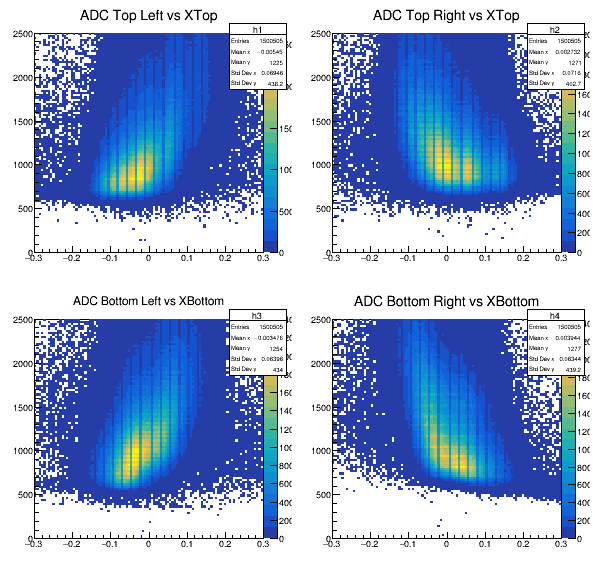

In [ ]:
c5 = root.TCanvas("c5", "c5", 125,125,600,600);
c5.Divide(2,2, 0.01, 0.01, 0);

hADCvsXTL = fdftttt.Histo2D(("h1","ADC Top Left vs XTop",bin,-0.3,0.3,bin,0,2500),"xtop","adctladj");
hADCvsXTR = fdftttt.Histo2D(("h2","ADC Top Right vs XTop",bin,-0.3,0.3,bin,0,2500),"xtop","adctradj");
hADCvsXBL = fdftttt.Histo2D(("h3","ADC Bottom Left vs XBottom",bin,-0.3,0.3,bin,0,2500),"xbottom","adcbladj");
hADCvsXBR = fdftttt.Histo2D(("h4","ADC Bottom Right vs XBottom",bin,-0.3,0.3,bin,0,2500),"xbottom","adcbradj");

c5.cd(1);
hADCvsXTL.Draw("COLZ");
c5.cd(2);
hADCvsXTR.Draw("COLZ");
c5.cd(3);
hADCvsXBL.Draw("COLZ");
c5.cd(4);
hADCvsXBR.Draw("COLZ");

c5.Draw();


In [ ]:
c7 = root.TCanvas("c7", "c7", 175,175,600,600);
c7.Divide(2,3, 0.01, 0.01, 0);

hXTop = fdftttt.Histo1D(("h1","Top Position",bin,-0.3,0.3),"xtop");
hXBottom = fdftttt.Histo1D(("h2","Bottom Position",bin,-0.3,0.3),"xbottom");
hXMeanTop = fdftttt.Histo1D(("h1","Mean Top Position",bin,-0.3,0.3),"xmeantop");
hXMeanBottom = fdftttt.Histo1D(("h2","Mean Bottom Position",bin,-0.3,0.3),"xmeanbottom");
hXMean = fdftttt.Histo1D(("h2","Mean Position",bin,-0.3,0.3),"xmean");
hTheta = fdftttt.Histo1D(("h3","Angle 1",bin,-100,100),"theta");
hTheta2 = fdftttt.Histo1D(("h4","Angle 2",bin,-100,100),"theta2");

c7.cd(1);
hXTop.Draw();
c7.cd(2);
hXBottom.Draw();
c7.cd(3);
hXMeanTop.Draw();
c7.cd(4);
hXMeanBottom.Draw();
c7.cd(5);
hXMean.Draw();
c7.cd(6);
hTheta.Draw();
hTheta2.SetFillColor(kRed);
hTheta2.Draw("SAME");

c7.Draw();

In [ ]:
c8 = root.TCanvas("c8", "c8", 200,200,600,600);
c8.Divide(1,2, 0.01, 0.01, 0);

hADCT = fdftttt.Histo1D(("h1","EDep Top",bin,0,6000),"etop");
hADCB = fdftttt.Histo1D(("h4","EDep Bottom",bin,0,6000),"ebottom");

c8.cd(1);
hADCT.Draw();
c8.cd(2);
hADCB.Draw();

c8.Draw();

In [ ]:
c9 = root.TCanvas("c9", "c9", 225,225,600,600);
c9.Divide(1,2, 0.01, 0.01, 0);

hADCT = fdftttt.Histo1D(("h1","EDep (Top: Blue, Bottom: Red)",bin,0,6000),"etop");
hADCB = fdftttt.Histo1D(("h4","EDep Bottom",bin,0,6000),"ebottom");
hADCR = fdftttt.Histo1D(("h4","EDep Ratio",bin,0,3.0),"eratio");

c9.cd(1);
hADCT.Draw();
hADCB.SetLineColor(kRed);
hADCB.Draw("SAME");
c9.cd(2);
hADCR.Draw();

c9.Draw();


In [ ]:
c10 = root.TCanvas("c10", "c10", 250,250,600,600);
c10.Divide(2,2, 0.01, 0.01, 0);

hADCTopvsTheta = fdftttt.Histo2D(("h1","ADC Top vs Theta",bin,-60,60,bin,0,4500),"theta","etop");
hADCBottomvsTheta = fdftttt.Histo2D(("h2","ADC Bottom vs Theta",bin,-60,60,bin,0,4500),"theta","ebottom");

c10.cd(1);
hADCTopvsTheta.Draw("COLZ");
c10.cd(2);
hADCBottomvsTheta.Draw("COLZ");

c10.cd(3);
myLeBronFit = TF1("myLeBronFit","[0]*(1.0+[1]*cos(x*3.14159/180.0))",-60.0,60.0);
prof = hADCTopvsTheta.ProfileX();
prof.Fit("myLeBronFit","QR");
prof.Draw();

c10.cd(4);
prof2 = hADCBottomvsTheta.ProfileX();
prof2.Fit("myLeBronFit","QR");
prof2.Draw();

c10.Draw();
